In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

try:
    df = pd.read_csv('sales.csv', encoding='latin1') 
except FileNotFoundError:
    print("Error: sales.csv not found. Make sure the file is in the project directory.")
    exit()

print("--- Initial Data Info ---")
df.info()
print("\n--- First 5 Rows ---")
print(df.head())
print("\n--- Missing Values Before Cleaning ---")
print(df.isnull().sum())
print("\n--- Data Types ---")
print(df.dtypes)

df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])

valid_statuses = ['Shipped', 'Resolved', 'In Process']
df_cleaned = df[df['STATUS'].isin(valid_statuses)].copy() 

sales_ts = df_cleaned.groupby('ORDERDATE')['SALES'].sum().reset_index()
sales_ts = sales_ts.rename(columns={'ORDERDATE': 'ds', 'SALES': 'y'})


sales_ts = sales_ts.sort_values('ds')

print("\n--- Aggregated Sales Data (First 5 Rows) ---")
print(sales_ts.head())
print("\n--- Aggregated Sales Data Info ---")
sales_ts.info()

date_range = pd.date_range(start=sales_ts['ds'].min(), end=sales_ts['ds'].max())
missing_dates = date_range[~date_range.isin(sales_ts['ds'])]
if not missing_dates.empty:
    print(f"\nWarning: There are {len(missing_dates)} missing dates in the aggregated time series.")
    
else:
    print("\nNo missing dates in the aggregated time series.")

print("\n--- Data Preprocessing Complete ---")

--- Initial Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ORDERNUMBER       2823 non-null   int64  
 1   QUANTITYORDERED   2823 non-null   int64  
 2   PRICEEACH         2823 non-null   float64
 3   ORDERLINENUMBER   2823 non-null   int64  
 4   SALES             2823 non-null   float64
 5   ORDERDATE         2823 non-null   object 
 6   STATUS            2823 non-null   object 
 7   QTR_ID            2823 non-null   int64  
 8   MONTH_ID          2823 non-null   int64  
 9   YEAR_ID           2823 non-null   int64  
 10  PRODUCTLINE       2823 non-null   object 
 11  MSRP              2823 non-null   int64  
 12  PRODUCTCODE       2823 non-null   object 
 13  CUSTOMERNAME      2823 non-null   object 
 14  PHONE             2823 non-null   object 
 15  ADDRESSLINE1      2823 non-null   object 
 16  ADDRESSLINE2    

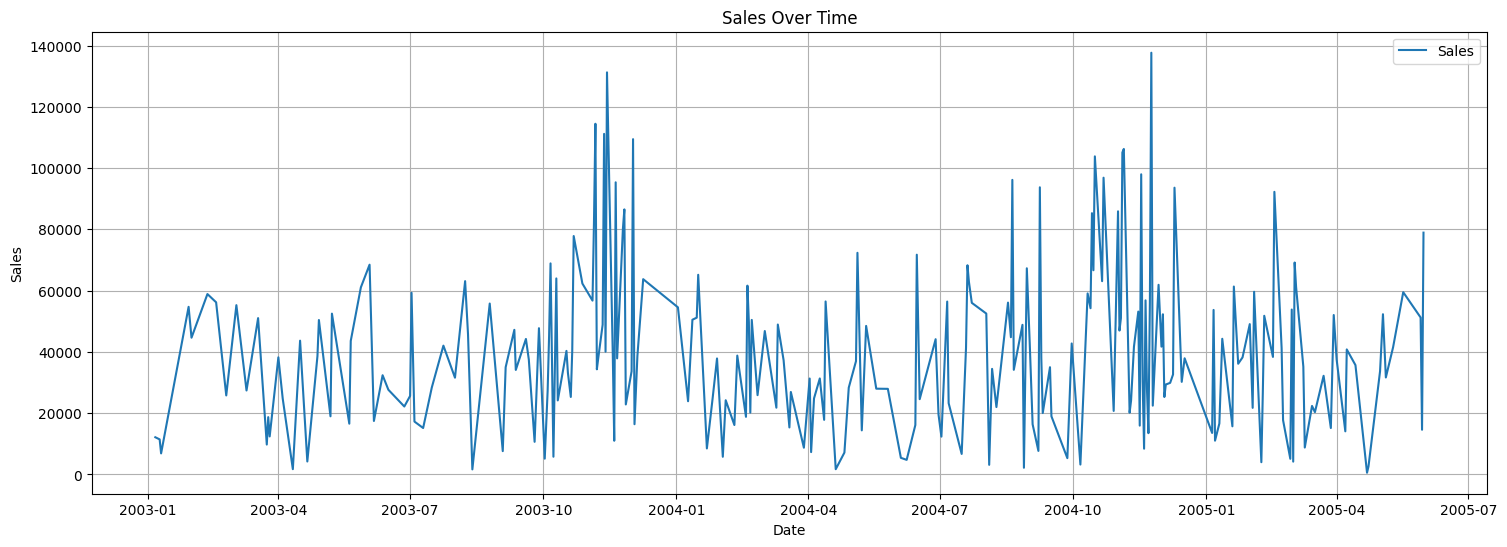

Could not perform yearly decomposition, possibly insufficient data: x must have 2 complete cycles requires 730 observations. x only has 243 observation(s)


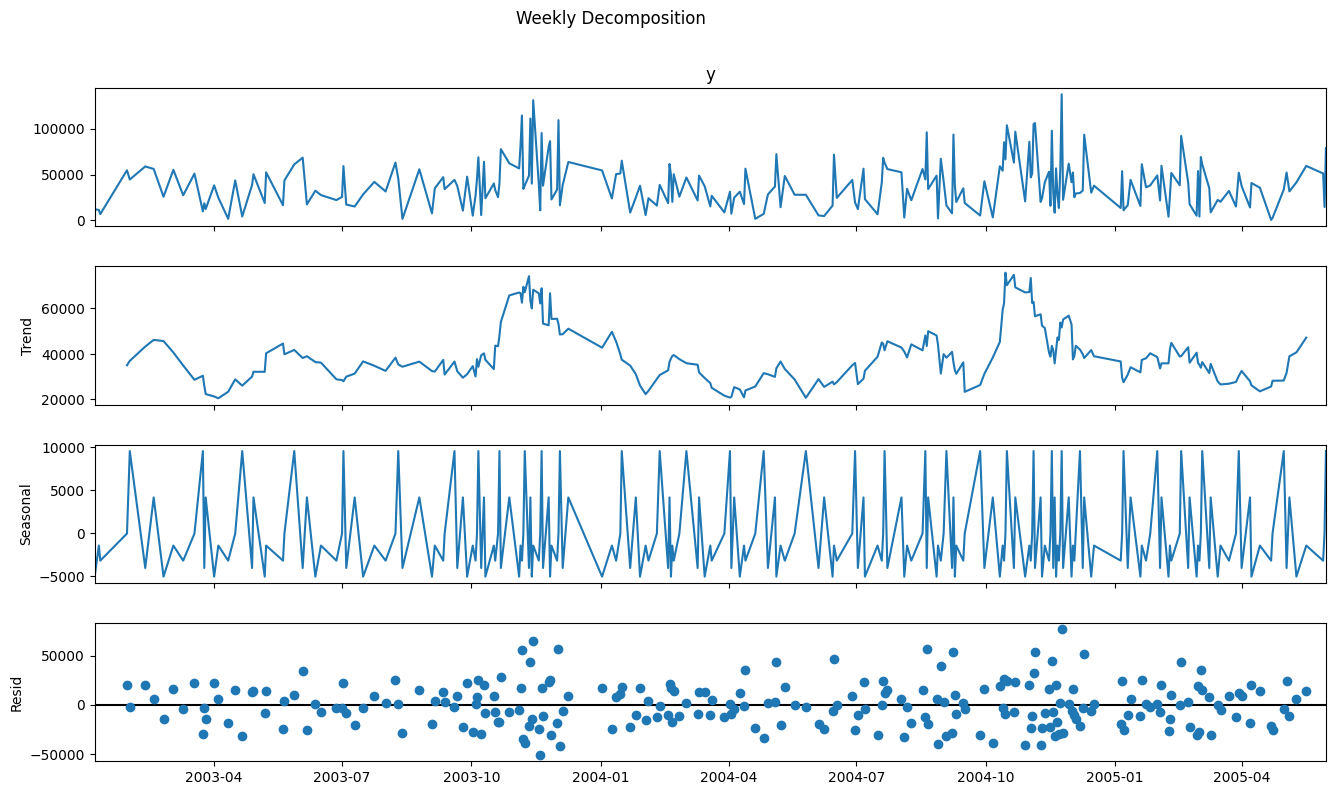

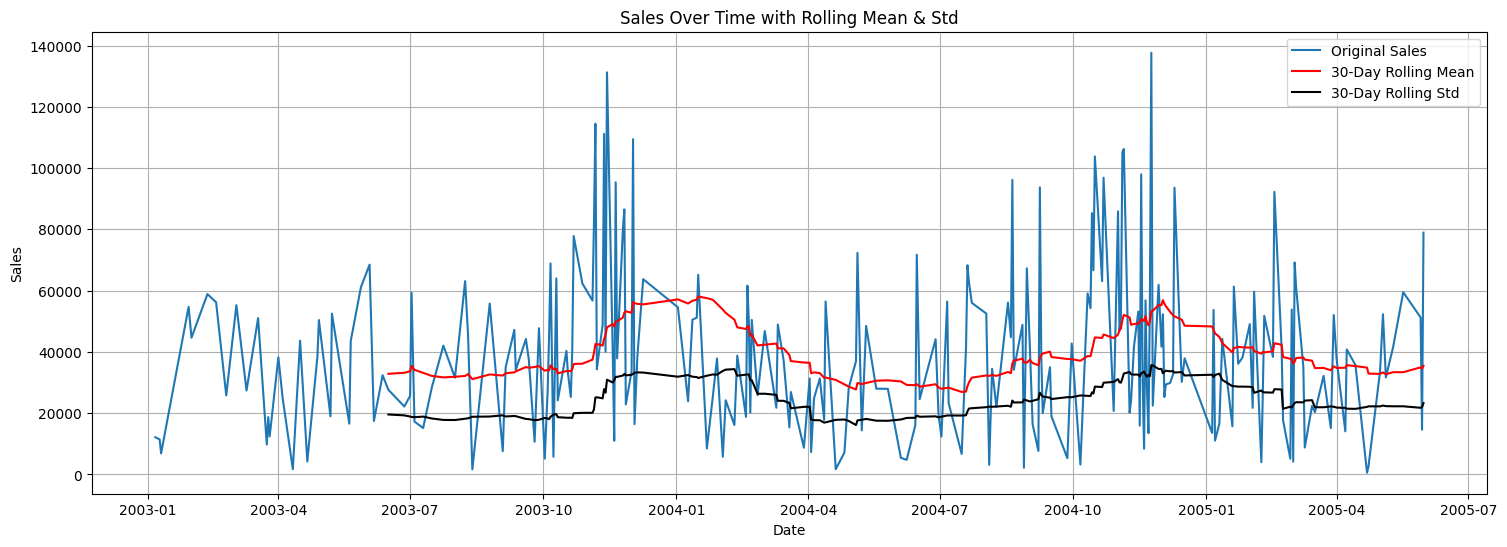

In [2]:
plt.figure(figsize=(18, 6))
plt.plot(sales_ts['ds'], sales_ts['y'], label='Sales')
plt.title('Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

from statsmodels.tsa.seasonal import seasonal_decompose

sales_ts_indexed = sales_ts.set_index('ds')

try:
    decomposition_yearly = seasonal_decompose(sales_ts_indexed['y'], model='additive', period=365)
    fig_yearly = decomposition_yearly.plot()
    fig_yearly.set_size_inches(15, 10)
    plt.suptitle('Yearly Decomposition', y=1.02)
    plt.show()
except ValueError as e:
    print(f"Could not perform yearly decomposition, possibly insufficient data: {e}")


if len(sales_ts_indexed) >= 2 * 7: 
    try:
        decomposition_weekly = seasonal_decompose(sales_ts_indexed['y'], model='additive', period=7)
        fig_weekly = decomposition_weekly.plot()
        fig_weekly.set_size_inches(15, 8)
        plt.suptitle('Weekly Decomposition', y=1.02)
        plt.show()
    except ValueError as e:
        print(f"Could not perform weekly decomposition, possibly insufficient data: {e}")
else:
    print("Not enough data for a meaningful weekly decomposition (need at least 14 days).")


# Rolling statistics
plt.figure(figsize=(18, 6))
plt.plot(sales_ts['ds'], sales_ts['y'], label='Original Sales')
plt.plot(sales_ts['ds'], sales_ts['y'].rolling(window=30).mean(), label='30-Day Rolling Mean', color='red')
plt.plot(sales_ts['ds'], sales_ts['y'].rolling(window=30).std(), label='30-Day Rolling Std', color='black')
plt.title('Sales Over Time with Rolling Mean & Std')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

Importing plotly failed. Interactive plots will not work.
23:10:27 - cmdstanpy - INFO - Chain [1] start processing
23:10:27 - cmdstanpy - INFO - Chain [1] done processing


Using date-based split: 198 train, 45 test samples.

--- Prophet Model Evaluation (on test set) ---
Mean Absolute Error (MAE): 15487.43
Mean Squared Error (MSE): 294496825.20
Root Mean Squared Error (RMSE): 17160.91
Mean Absolute Percentage Error (MAPE): 68.28%


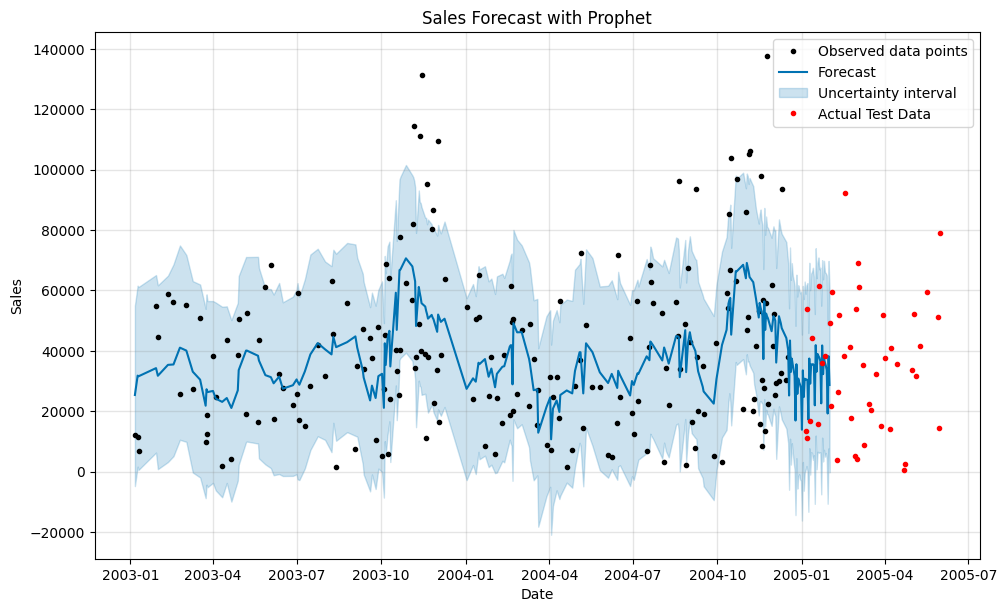

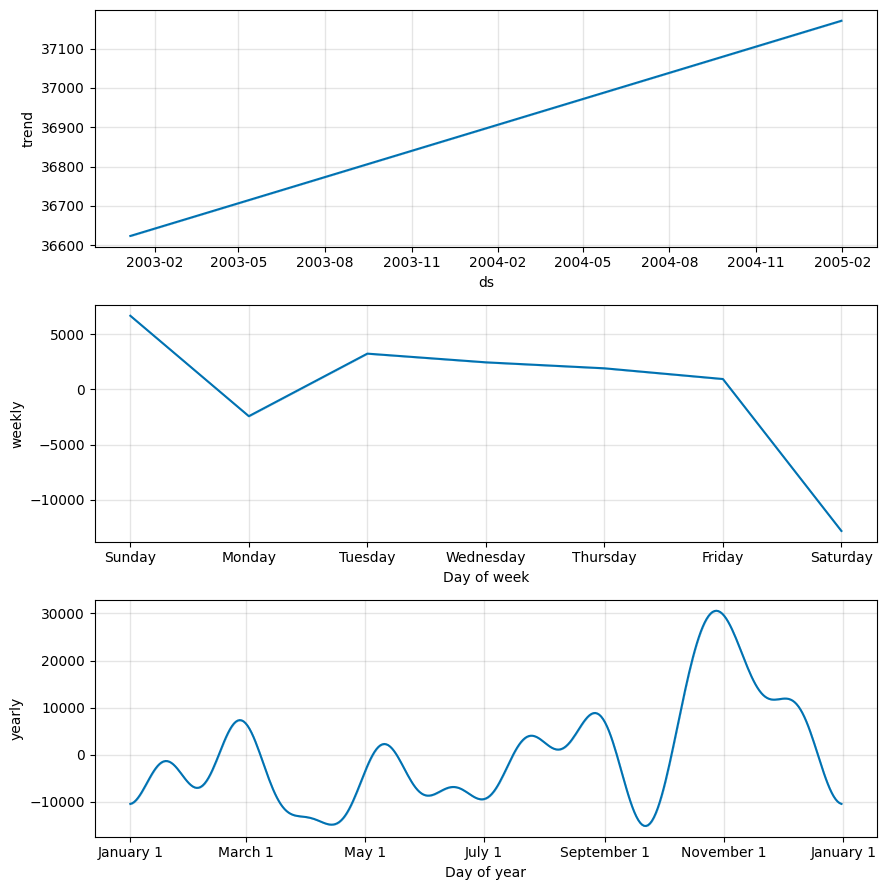

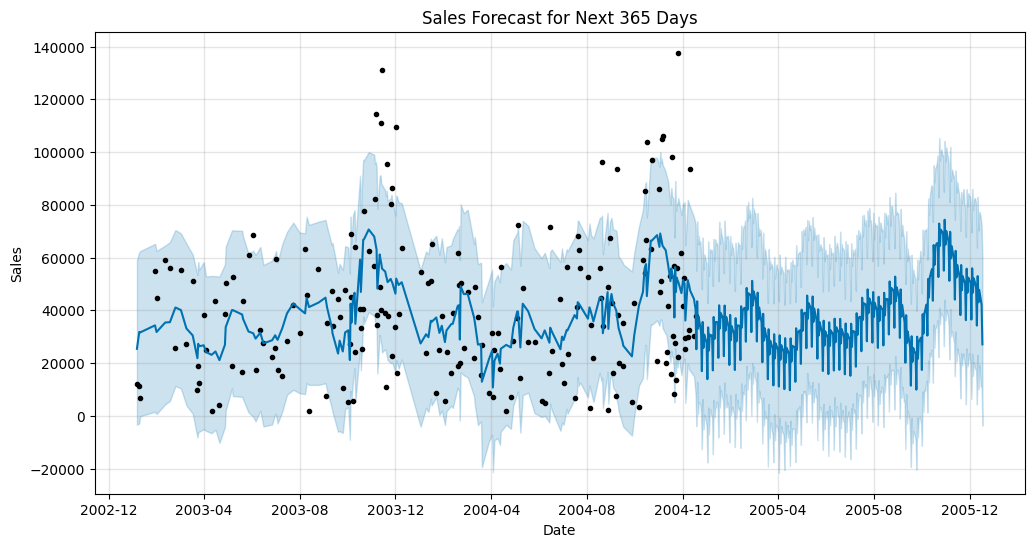


--- Prophet Modeling Complete ---


In [3]:
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from sklearn.metrics import mean_absolute_error, mean_squared_error


train_df = sales_ts[sales_ts['ds'] < '2005-01-01']
test_df = sales_ts[sales_ts['ds'] >= '2005-01-01']

if train_df.empty or test_df.empty:
    print("Train or test DataFrame is empty. Adjust split point or check data range.")
    split_point = int(len(sales_ts) * 0.85)
    train_df = sales_ts[:split_point]
    test_df = sales_ts[split_point:]
    if train_df.empty or test_df.empty:
        print("Fallback split also failed. Exiting.")
        exit()
    print(f"Using fallback split: {len(train_df)} train, {len(test_df)} test samples.")
else:
    print(f"Using date-based split: {len(train_df)} train, {len(test_df)} test samples.")


model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)

model.fit(train_df)

future_dates = model.make_future_dataframe(periods=len(test_df), freq='D') 
forecast = model.predict(future_dates)

forecast_test_period = forecast[forecast['ds'].isin(test_df['ds'])]

if not forecast_test_period.empty and not test_df.empty:
    
    aligned_test_df = pd.merge(forecast_test_period[['ds']], test_df, on='ds', how='inner')

    if not aligned_test_df.empty:
        y_true = aligned_test_df['y'].values
        y_pred = forecast_test_period[forecast_test_period['ds'].isin(aligned_test_df['ds'])]['yhat'].values

        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

        print("\n--- Prophet Model Evaluation (on test set) ---")
        print(f'Mean Absolute Error (MAE): {mae:.2f}')
        print(f'Mean Squared Error (MSE): {mse:.2f}')
        print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
        print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

        fig1 = model.plot(forecast)
        plt.title('Sales Forecast with Prophet')
        plt.xlabel('Date')
        plt.ylabel('Sales')
        
        plt.plot(test_df['ds'], test_df['y'], '.r', label='Actual Test Data')
        plt.legend()
        plt.show()

        fig2 = model.plot_components(forecast)
        plt.show()

       
    else:
        print("Could not align forecast with test data for evaluation. Dates might not overlap perfectly.")
else:
    print("Forecast or test period is empty, skipping evaluation and detailed plotting.")

future_full_dates = model.make_future_dataframe(periods=365, freq='D')
full_forecast = model.predict(future_full_dates)

plt.figure(figsize=(12,6))
model.plot(full_forecast, ax=plt.gca())
plt.title('Sales Forecast for Next 365 Days')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

print("\n--- Prophet Modeling Complete ---")


--- Regression DataFrame with Features (First 5 Rows) ---
           ds         y     timestamp  year  month  dayofweek  dayofyear  \
30 2003-06-27  22167.74  1.056672e+09  2003      6          4        178   
31 2003-07-01  25624.88  1.057018e+09  2003      7          1        182   
32 2003-07-02  59280.51  1.057104e+09  2003      7          2        183   
33 2003-07-04  17251.08  1.057277e+09  2003      7          4        185   
34 2003-07-10  15146.32  1.057795e+09  2003      7          3        191   

    weekofyear   y_lag_1   y_lag_7  y_lag_30  
30          26  27628.30  16560.30  12133.25  
31          27  22167.74  43585.80  11432.34  
32          27  25624.88  61073.21   6864.05  
33          27  59280.51  68462.15  54702.00  
34          28  17251.08  17448.08  44621.96  

--- Training RandomForestRegressor ---

--- Scikit-learn RandomForestRegressor Evaluation ---
Mean Absolute Error (MAE): 18191.45
Root Mean Squared Error (RMSE): 21519.75
Mean Absolute Percentage Error

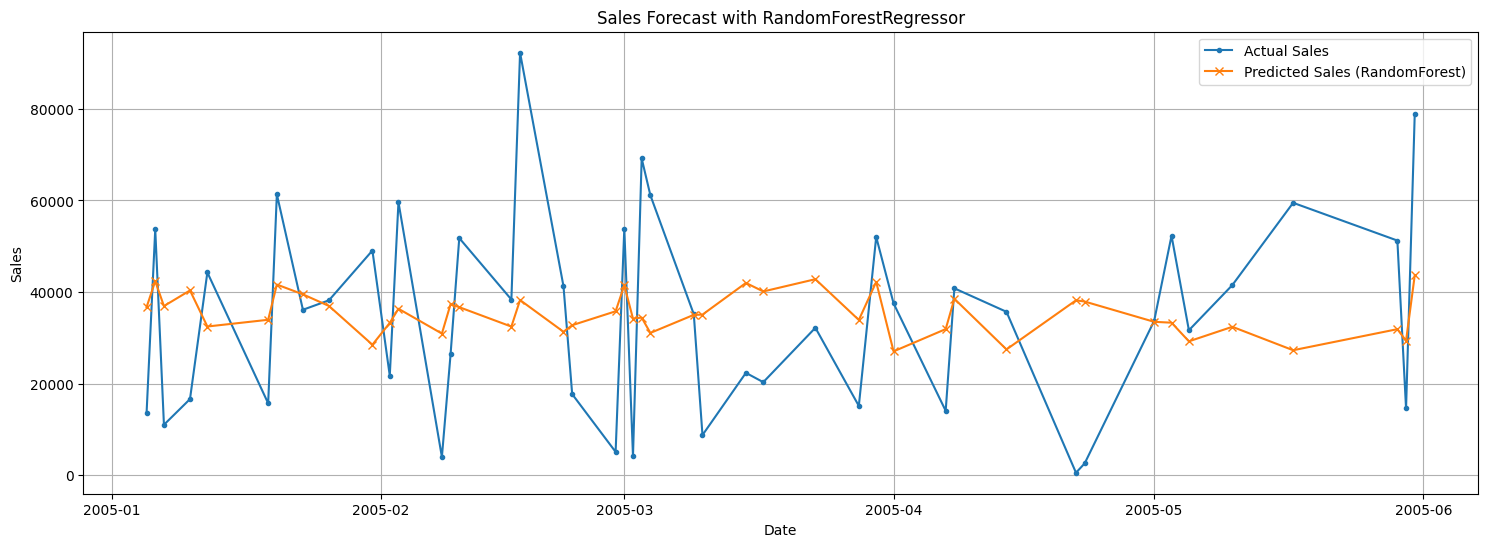


--- Scikit-learn Modeling Complete ---


In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split 

regression_df = sales_ts.copy()
regression_df['timestamp'] = regression_df['ds'].map(pd.Timestamp.timestamp) 
regression_df['year'] = regression_df['ds'].dt.year
regression_df['month'] = regression_df['ds'].dt.month
regression_df['dayofweek'] = regression_df['ds'].dt.dayofweek 
regression_df['dayofyear'] = regression_df['ds'].dt.dayofyear
regression_df['weekofyear'] = regression_df['ds'].dt.isocalendar().week.astype(int)


for lag in [1, 7, 30]: 
    regression_df[f'y_lag_{lag}'] = regression_df['y'].shift(lag)

regression_df = regression_df.dropna()

if not regression_df.empty:
    print("\n--- Regression DataFrame with Features (First 5 Rows) ---")
    print(regression_df.head())

    X = regression_df.drop(['ds', 'y'], axis=1)
    y_reg = regression_df['y']


    split_date_reg = pd.Timestamp('2005-01-01')
    train_mask_reg = regression_df['ds'] < split_date_reg
    test_mask_reg = regression_df['ds'] >= split_date_reg

    X_train_reg, X_test_reg = X[train_mask_reg], X[test_mask_reg]
    y_train_reg, y_test_reg = y_reg[train_mask_reg], y_reg[test_mask_reg]
    
    dates_test_reg = regression_df['ds'][test_mask_reg]


    if X_train_reg.empty or X_test_reg.empty:
        print("Train or test set for regression is empty. Adjusting split or skipping.")
    else:

        print("\n--- Training RandomForestRegressor ---")
        rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        rf_model.fit(X_train_reg, y_train_reg)

        y_pred_reg = rf_model.predict(X_test_reg)

        mae_reg = mean_absolute_error(y_test_reg, y_pred_reg)
        mse_reg = mean_squared_error(y_test_reg, y_pred_reg)
        rmse_reg = np.sqrt(mse_reg)
        mape_reg = np.mean(np.abs((y_test_reg - y_pred_reg) / y_test_reg)) * 100

        print("\n--- Scikit-learn RandomForestRegressor Evaluation ---")
        print(f'Mean Absolute Error (MAE): {mae_reg:.2f}')
        print(f'Root Mean Squared Error (RMSE): {rmse_reg:.2f}')
        print(f'Mean Absolute Percentage Error (MAPE): {mape_reg:.2f}%')

        plt.figure(figsize=(18, 6))
        plt.plot(dates_test_reg, y_test_reg.values, label='Actual Sales', marker='.')
        plt.plot(dates_test_reg, y_pred_reg, label='Predicted Sales (RandomForest)', marker='x')
        plt.title('Sales Forecast with RandomForestRegressor')
        plt.xlabel('Date')
        plt.ylabel('Sales')
        plt.legend()
        plt.grid(True)
        plt.show()
else:
    print("Regression DataFrame is empty after feature engineering (likely due to lags). Skipping regression part.")

print("\n--- Scikit-learn Modeling Complete ---")